In [1]:
# Import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset and Parameters

n_features = 64
num_classes = 10
data = pd.read_csv('dataset/optdigits.tra.csv',  header=None)
train_input = data.iloc[:, :n_features].as_matrix()
train_target = data.iloc[:, n_features].as_matrix()

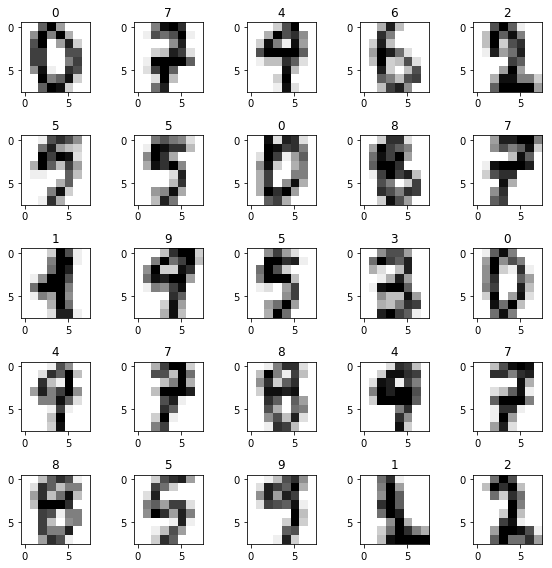

In [3]:
# Show first 25 samples
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(train_input[i].reshape(8, 8), cmap='gray_r')
    plt.title(train_target[i])
plt.tight_layout()
plt.show()

In [54]:
# Make them to Variable
X = Variable(torch.Tensor(train_input).float())
Y = Variable(torch.Tensor(train_target).long())
data_test = pd.read_csv('dataset/optdigits.tes.csv',  header=None)
train_input_test = data_test.iloc[:, :n_features].as_matrix()
train_target_test = data_test.iloc[:, n_features].as_matrix()
X_test = Variable(torch.Tensor(train_input_test).float())
Y_test = Variable(torch.Tensor(train_target_test).long())

In [55]:
# Define a two layer neural network, which is for fully-connected layer
# Function hidden_layer help to get hidden layer result

class Net_ann(nn.Module):
    
    def __init__(self, hidden_size):
        super(Net_ann, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(64, hidden_size) 
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        hidden_unit = out
        out = self.fc2(out)
        return out
    
    def hidden_layer(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        return out

In [7]:
# Train function: notice that for each epoch, I will use the current 
# neural network to get losses and accuracy for test set. I will
# keep all result in some lists. Therefore, I can easily plot all 
# losses and accuracy for train set and test set, which will help us
# to see trend of them.

def train(net, num_epochs, X, Y, if_plot=True):
    if if_plot:
        print('Starting training...')
        print('Number of epochs:', num_epochs)
        print('==============================')
        print('Progress: ', end='')
        train_losses = []
        test_losses = []
        train_accuracy = []
        test_accuracy = []
    
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        if if_plot and epoch % (num_epochs / 20) == 0:
            print('#', end='')
            
        Y_pred = net(X)
        loss = criterion(Y_pred, Y)
        
        if if_plot:
            Y_pred_test = net(X_test)
            loss_test = criterion(Y_pred_test, Y_test)
            train_losses.append(loss.data[0])
            test_losses.append(loss_test.data[0])

            _, predicted = torch.max(Y_pred, 1)
            total = predicted.size(0)
            correct = predicted.data.numpy() == Y.data.numpy()
            train_accuracy.append(100 * sum(correct)/total)

            _, predicted_test = torch.max(Y_pred_test, 1)
            total_test = predicted_test.size(0)
            correct_test = predicted_test.data.numpy() == Y_test.data.numpy()
            test_accuracy.append(100 * sum(correct_test)/total_test)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # plot the losses and acuracy of train set and test set from each epoch.
    if if_plot:
        plt_result(train_losses, test_losses, train_accuracy, test_accuracy)
        # print final accuracy for train set and test set
        print()
        print('Final train set accuracy: {0:.4f}%'.format(train_accuracy[-1]))
        print('Final test set accuracy: {0:.4f}%'.format(test_accuracy[-1]))

def get_accuracy(net, X_test, Y_test):
    Y_pred_test = net(X_test)
    _, predicted_test = torch.max(Y_pred_test, 1)
    total_test = predicted_test.size(0)
    correct_test = sum(predicted_test.data.numpy() == Y_test.data.numpy())
    return 100 * correct_test / total_test
    
def plt_result(train_losses, test_losses, train_accuracy, test_accuracy):
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.ylabel('cost')
    plt.plot(train_losses, label='train set')
    plt.plot(test_losses, label='test set')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(train_accuracy, label='train set')
    plt.plot(test_accuracy, label='test set')
    plt.legend()
    plt.show()

In [22]:
# To remove redundant units. Notice that threshold 
# and hidden_size are parameters

def remove_redundant_units_ann(net, X, threshold=15, if_print=True):
    hidden_units = net.hidden_layer(X).data.numpy()
    weight = net.fc2.weight.data.numpy().copy()
    removed = set()
    num_removed = 0
    
#     for i in range(hidden_size):
#         a = hidden_units[:, i].reshape(-1, 1)
#         if np.linalg.norm(a) < num_train * 0.01:
#             print('hidden unit: {0:2d}   norm: {1:.2f}'.format(i, np.linalg.norm(a)))
#             removed.add(i)
#             weight2[:, i].fill(0)
#             num_removed += 1
#     else:
#         print('There is no unit close to 0')

    if if_print:
        print('{:8}{:8}'.format('Units','Angle'))
    for i in range(net.hidden_size):
        if i in removed:
            continue
        a = hidden_units[:, i].reshape(-1, 1)
        for j in range(i+1, net.hidden_size):
            if j in removed:
                continue
            b = hidden_units[:, j].reshape(-1, 1)
            cos = np.asscalar(a.T @ b / (np.linalg.norm(a) * np.linalg.norm(b)))
            cos = min(cos, 1)
            cos = max(cos, -1)
            angle = np.arccos(cos) * 180 / np.pi
            if angle < threshold:
                if if_print:
                    print('{0:4d} {1:4d}    {2:.4f}'.format(i, j, angle))
                removed.add(j)
                weight[:, i] += weight[:, j]
                weight[:, j].fill(0)
                num_removed += 1
            if angle > 180 - threshold:
                if if_print:
                    print('{0:4d} {1:4d}    {2:.4f}'.format(i, j, angle))
                removed.add(j)
                weight[:, i] -= weight[:, j]
                weight[:, j].fill(0)
                num_removed += 1
    return weight, num_removed

Number of hidden units: 50
Starting training...
Number of epochs: 100
Progress: ####################

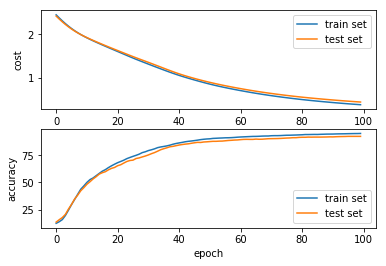


Final train set accuracy: 95.1086%
Final test set accuracy: 92.4318%
Number of hidden units: 100
Starting training...
Number of epochs: 100
Progress: ####################

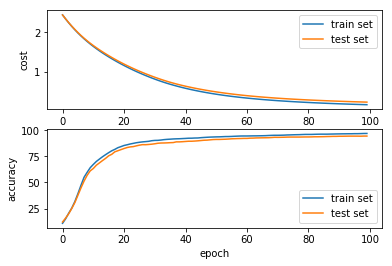


Final train set accuracy: 97.1227%
Final test set accuracy: 94.6021%
Number of hidden units: 150
Starting training...
Number of epochs: 100
Progress: ####################

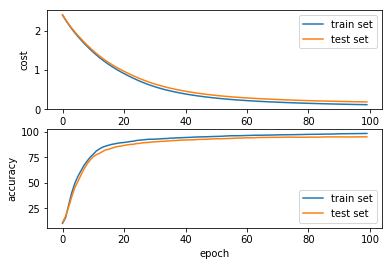


Final train set accuracy: 98.2998%
Final test set accuracy: 94.9917%
Number of hidden units: 200
Starting training...
Number of epochs: 100
Progress: ####################

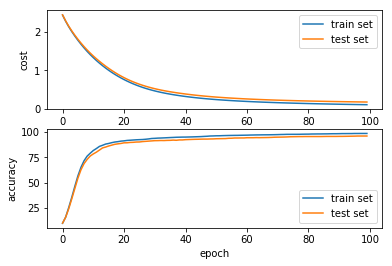


Final train set accuracy: 98.3521%
Final test set accuracy: 95.8264%


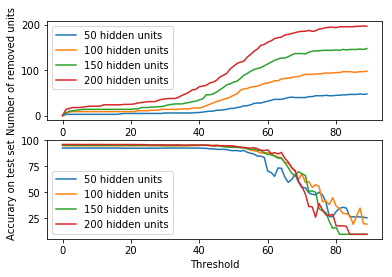

In [41]:
num_epochs = 100
num_removed_unit = []
acc = []
for i in range(4):
    hidden_size = (i+1) * 50
    num_removed_unit.append([])
    acc.append([])
    print('Number of hidden units:', hidden_size)
    net = Net_ann(hidden_size)
    train(net, num_epochs, X, Y)
    original_weight = net.fc2.weight.data.numpy().copy()
    for threshold in range(90):
#         print('Threshold:', threshold)
        net.fc2.weight.data = torch.from_numpy(original_weight)
        weight, num_removed = remove_redundant_units_ann(net, X, threshold=threshold, if_print=False)
#         print('Number of removed units:', num_removed)
        num_removed_unit[i].append(num_removed)
        net.fc2.weight.data = torch.from_numpy(weight)
        acc[i].append(get_accuracy(net, X_test, Y_test))
#         print('After remove units, test set ccuracy: {0:.4f}%'.format(get_accuracy(net, X_test, Y_test)))
#         print()

for i in range(4):
    hidden_size = (i+1) * 50
    plt.subplot(211)
    plt.plot(range(90), num_removed_unit[i], label=str(hidden_size)+' hidden units')
    plt.title('')
    plt.subplot(212)
    plt.plot(range(90), acc[i], label=str(hidden_size)+' hidden units')
plt.subplot(211)
plt.title('')
plt.xlabel('Threshold')
plt.ylabel('Number of removed units')
plt.legend()
plt.subplot(212)
plt.xlabel('Threshold')
plt.ylabel('Accurary on test set')
plt.legend()
plt.show()

In [59]:
X = Variable(torch.FloatTensor(train_input).contiguous().view(-1, 1, 8, 8))
X_test = Variable(torch.FloatTensor(train_input_test).contiguous().view(-1, 1, 8, 8))

# Define a convolutional neural network
# Function hidden_layer help to get hidden layer result

class Net_cnn(nn.Module):
    def __init__(self, filter_num):
        super(Net_cnn, self).__init__()
        self.filter_num = filter_num
        self.conv1 = nn.Conv2d(1, filter_num, 5)
        self.fc1 = nn.Linear(filter_num * 4 * 4, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = x.view(-1, self.filter_num * 4 * 4)
        x = self.fc1(x)
        return x
    
    def middle_result(self, x):
        x = F.tanh(self.conv1(x))
        return x    

In [61]:
def remove_redundant_units_cnn(net, X, threshold=15, if_print=True):
    hidden_units = net.middle_result(X).data.numpy().copy()
    weight = net.conv1.weight.data.numpy().copy()
    bias = net.conv1.bias.data.numpy().copy()
    removed = set()
    num_removed = 0
    if if_print:
        print('{:8}{:8}'.format('Units','Angle'))
    for i in range(net.filter_num):
        if i in removed:
            continue
        a = hidden_units[:, i].reshape(-1, 1)
        for j in range(i+1, net.filter_num):
            if j in removed:
                continue
            b = hidden_units[:, j].reshape(-1, 1)
            cos = np.asscalar(a.T @ b / (np.linalg.norm(a) * np.linalg.norm(b)))
            cos = min(cos, 1)
            cos = max(cos, -1)
            angle = np.arccos(cos) * 180 / np.pi
            if angle < threshold:
                if if_print:
                    print('{0:4d} {1:4d}    {2:.4f}'.format(i, j, angle))
                removed.add(j)
                weight[i, :] += weight[j, :]
                weight[j, :].fill(0)
                bias[i] += bias[j]
                bias[j].fill(0)
                num_removed += 1
            if angle > 180 - threshold:
                if if_print:
                    print('{0:4d} {1:4d}    {2:.4f}'.format(i, j, angle))
                removed.add(j)
                weight[i, :] -= weight[j, :]
                weight[j, :].fill(0)
                bias[i] -= bias[j]
                bias[j].fill(0)
                num_removed += 1
    return weight, bias, num_removed

Number of filters: 50
Starting training...
Number of epochs: 50
Progress: ##########

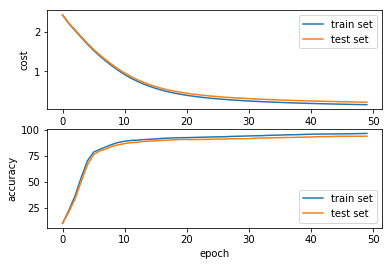


Final train set accuracy: 96.7826%
Final test set accuracy: 94.1013%
Number of filters: 100
Starting training...
Number of epochs: 50
Progress: ##########

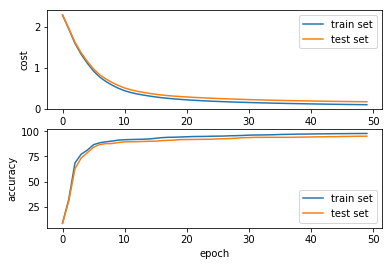


Final train set accuracy: 97.9336%
Final test set accuracy: 95.2142%
Number of filters: 150
Starting training...
Number of epochs: 50
Progress: ##########

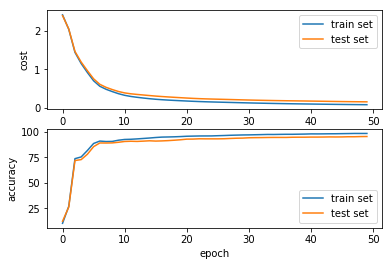


Final train set accuracy: 98.1428%
Final test set accuracy: 95.1586%
Number of filters: 200
Starting training...
Number of epochs: 50
Progress: ##########

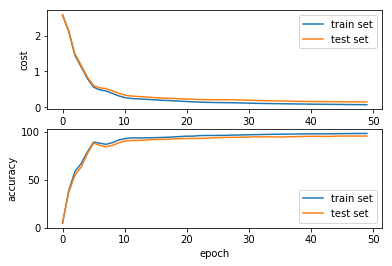


Final train set accuracy: 98.1951%
Final test set accuracy: 95.4925%


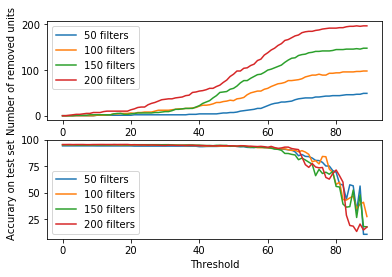

In [66]:
num_epochs = 50
num_removed_unit = []
acc = []
for i in range(4):
    filter_num = (i+1) * 50
    num_removed_unit.append([])
    acc.append([])
    print('Number of filters:', filter_num)
    net = Net_cnn(filter_num)
    train(net, num_epochs, X, Y)
    original_weight = net.conv1.weight.data.numpy().copy()
    original_bias = net.conv1.bias.data.numpy().copy()
    for threshold in range(90):
#         print('Threshold:', threshold)
        net.conv1.weight.data = torch.from_numpy(original_weight)
        net.conv1.bias.data = torch.from_numpy(original_bias)
        weight, bias, num_removed = remove_redundant_units_cnn(net, X, threshold=threshold, if_print=False)
#         print('Number of removed units:', num_removed)
        net.conv1.weight.data = torch.from_numpy(weight)
        net.conv1.bias.data = torch.from_numpy(bias)
        num_removed_unit[i].append(num_removed)
        acc[i].append(get_accuracy(net, X_test, Y_test))
#         print('After remove units, test set ccuracy: {0:.4f}%'.format(get_accuracy(net, X_test, Y_test)))
#         print()
for i in range(4):
    hidden_size = (i+1) * 50
    plt.subplot(211)
    plt.plot(range(90), num_removed_unit[i], label=str(hidden_size)+' filters')
    plt.title('')
    plt.subplot(212)
    plt.plot(range(90), acc[i], label=str(hidden_size)+' filters')
plt.subplot(211)
plt.title('')
plt.xlabel('Threshold')
plt.ylabel('Number of removed units')
plt.legend()
plt.subplot(212)
plt.xlabel('Threshold')
plt.ylabel('Accurary on test set')
plt.legend()
plt.show()

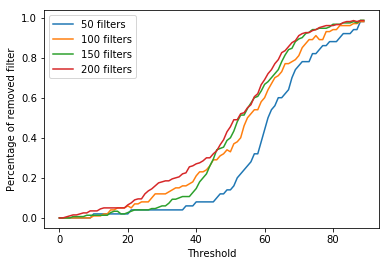

In [70]:
for i in range(4):
    hidden_size = (i+1) * 50
    plt.plot(range(90), [ t / hidden_size for t in num_removed_unit[i]], label=str(hidden_size)+' filters')
plt.title('')
plt.xlabel('Threshold')
plt.ylabel('Percentage of removed filter')
plt.legend()
plt.show()